In [19]:
%reset
import unittest
import sys
sys.path.append("../tests")

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import unitary_group

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [51]:
from component_layers import MZI, MZILayer, OpticalMesh, PhaseShifter, PhaseShifterLayer
from layers import *
from losses import *
from utils import *
from models import *
from optimizers import *
from settings import *
from base import *
from nonlinearities import *
from test_models import *

In [52]:
# reproduce the notebook line by line
X_ring, Y_ring = generate_ring_planar_dataset()

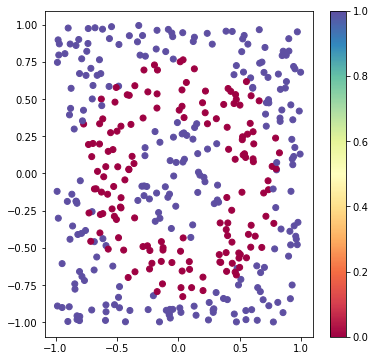

In [53]:
# X.shape
# Y the labels
labels = np.array([0 if yi[0] > yi[1] else 1 for yi in Y_ring]).flatten()

plt.figure(figsize=(6,6))
plt.scatter((X_ring.T)[0, :], (X_ring.T)[1, :], c=labels, cmap=plt.cm.Spectral)
plt.colorbar()
plt.show()

In [54]:
X_plane, Y_plane = generate_separable_planar_dataset()

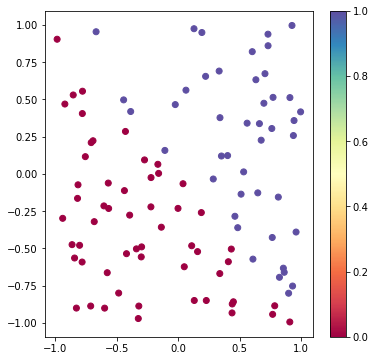

In [55]:
labels = np.array([0 if yi[0] > yi[1] else 1 for yi in Y_plane]).flatten()

plt.figure(figsize=(6,6))
plt.scatter((X_plane.T)[0, :], (X_plane.T)[1, :], c=labels, cmap=plt.cm.Spectral)
plt.colorbar()
plt.show()

In [56]:
X_diag, Y_diag = generate_diagonal_planar_dataset()

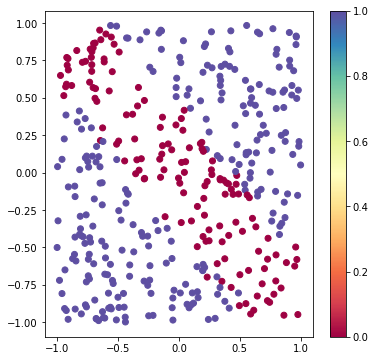

In [57]:
labels = np.array([0 if yi[0] > yi[1] else 1 for yi in Y_diag]).flatten()

plt.figure(figsize=(6,6))
plt.scatter((X_diag.T)[0, :], (X_diag.T)[1, :], c=labels, cmap=plt.cm.Spectral)
plt.colorbar()
plt.show()

In [67]:
def normalize_inputs(data, num_inputs, P0 = 10):
    '''
    Reshapes the inputs to fit into the specified mesh size and normalizes input data to 
    have the same total power input by injecting extra power to an "unused" input port.
    :param X: the input data
    :param num_inputs: the size of the network (number of waveguides)
    :param P0: the total power to inject with each data input
    '''
    _, input_size = data.shape
    injection_port = input_size
    data_normalized = np.array(np.pad(data, ((0, 0), (0, num_inputs - input_size)), mode="constant"))
    for i, x in enumerate(data_normalized):
        data_normalized[i][injection_port] = np.sqrt(P0 - np.sum(x**2))
    return data_normalized


def plot_planar_boundary(X, Y, model, grid_points=20, P0=10):
    '''
    Plots the decision boundary for a model predicting planar datasets
    :param X: shape (n_features, n_samples), first two features are x, y coordinates
    :param Y: true labeles, (n_features, n_samples)
    :param model: a trained neuroptica model
    :param grid_points: number of grid points to render
    :param P0: normalization power to shine into other ports to keep total power equal
    :return:
    '''
    
    labels = np.array([0 if yi[0] > yi[1] else 1 for yi in np.abs(Y)]).flatten() # True labels

    # Prepare a grid of inputs to predict
    x_min, y_min = np.min(X, axis=0)[0:2]
    x_max, y_max = np.max(X, axis=0)[0:2]
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_points), np.linspace(x_min, x_max, grid_points))
    N = model.layers[0].input_size
    inputs = np.array([xx.flatten(), yy.flatten()]).T
    inputs = normalize_inputs(inputs, N, P0=P0).T

    # Predict the function value for the whole grid
    Y_hat = model.forward_pass(inputs).T
    Y_hat = [(0 if yhat[0] > yhat[1] else 1) for yhat in Y_hat]
    Z = np.array(Y_hat).reshape(xx.shape)

    # Plot the contour and training examples
    plt.figure(figsize=(7.5, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:,0], X[:,1], c=labels, cmap=plt.cm.Spectral)

    plt.ylabel(r'x_2')
    plt.xlabel(r'x_1')
    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])
    plt.colorbar()
    plt.show()

In [59]:
# the goal is to get the good inference, and good backward propagation

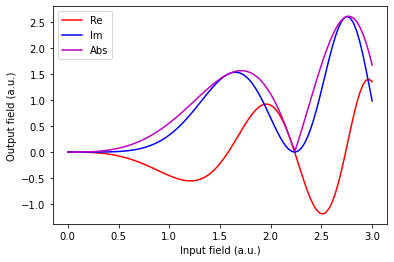

In [60]:
eo_settings = { 'alpha': 0.1,
                'g':     0.4 * np.pi,
                'phi_b': -1 * np.pi }

eo_activation = ElectroOpticActivation(1, **eo_settings)

x = np.linspace(0, 3, 100)
plt.plot(x, np.real(eo_activation.forward_pass(x)),label="Re", color = 'r')
plt.plot(x, np.imag(eo_activation.forward_pass(x)),label="Im", color = 'b')
plt.plot(x, np.abs(eo_activation.forward_pass(x)), label="Abs", color = 'm')
plt.xlabel("Input field (a.u.)")
plt.ylabel("Output field (a.u.)")
plt.legend()
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

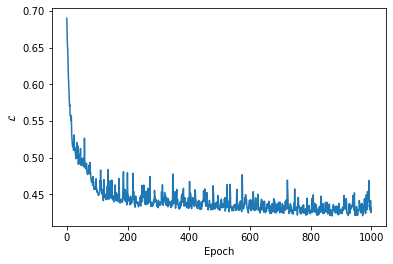

In [65]:
N = 5
P0 = 10.0

model = Sequential([
    ClementsLayer(N),
    Activation(ElectroOpticActivation(N, **eo_settings)),
    ClementsLayer(N),
    Activation(ElectroOpticActivation(N, **eo_settings)),
    ClementsLayer(N),
    Activation(ElectroOpticActivation(N, **eo_settings)),
    ClementsLayer(N),
    Activation(ElectroOpticActivation(N, **eo_settings)),
    ClementsLayer(N),
    Activation(AbsSquared(N)), # photodetector measurement
    DropMask(N, keep_ports=[0,1])
])

X_normalized = normalize_inputs(X_ring, N, P0=P0)

optimizer = InSituAdam(model, CategoricalCrossEntropy, step_size=0.005)
losses = optimizer.fit(X_normalized.T, Y_ring.T, epochs=1000, batch_size=32)

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("$\mathcal{L}$")
plt.show()

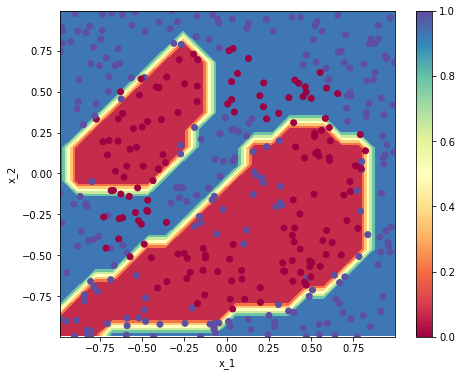

In [68]:
plot_planar_boundary(X_ring, Y_ring, model)